In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score
import json
import csv

In [3]:
N_WAVELENGTH = 228
LOD_HISTAMINE = 100
INDEX_HISTAMINE = 14
NAME_COLUMNS_HISTAMINE ='Histamine\n(mg/kg)'

In [4]:
df = pd.read_csv("data_NIRS/merged_db_Histamine.csv")
# df = df.drop_duplicates().reset_index()
df_copy = df.copy()

columns_wl = {}
for i, col in enumerate(df.columns[-N_WAVELENGTH:]):
    columns_wl[col] = str(i+1)
    
df.rename(columns=columns_wl, inplace=True)
df.head()

,Mã mẫu NIRS,Nhóm đo,Chỉ tiêu đo,Loại cá,Địa điểm lấy mẫu,STT mẫu cá,Vị trí đo,Lần lặp,Phương pháp đo,Ngày đo,...,219,220,221,222,223,224,225,226,227,228
0,2231001a1,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",1,Hadamard 1,13/11/21,...,1.260815,1.255657,1.276434,1.322620,1.304198,1.285766,1.306818,1.267184,1.411523,1.352860
1,2231001a2,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",2,Hadamard 1,13/11/21,...,1.213489,1.231890,1.313393,1.314022,1.395009,1.452664,1.381067,1.484528,1.253933,1.233967
2,2231001a3,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",3,Hadamard 1,13/11/21,...,1.219571,1.272744,1.342526,1.342042,1.482628,1.419886,1.392945,1.367681,1.254773,1.268085
3,2231001a4,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",4,Hadamard 1,13/11/21,...,1.233272,1.338020,1.459565,1.392858,1.357045,1.388063,1.224139,1.248838,1.209269,1.289710
4,2231001a5,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",5,Hadamard 1,13/11/21,...,1.293733,1.310010,1.346611,1.232961,1.253616,1.209367,1.164405,1.251315,1.179963,1.086338


# Xử lý dữ liệu NaN và vô hạn

In [5]:
print(f'Tổng các điểm dữ liệu trống trước xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn trước xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống trước xử lý: 2376
Tổng các điểm dữ liệu vô hạn trước xử lý: 9


In [6]:
# Lấy tất cả vị trí của các trị trống hoặc vô hạn
null_check = df.isna()
indices_null = np.argwhere(null_check.to_numpy() == True)

inf_check = np.isinf(df.iloc[:,-N_WAVELENGTH:])
indices_inf = np.argwhere(inf_check.to_numpy()== True)
indices_inf[:,1] += df.shape[1] - N_WAVELENGTH

indices = np.concatenate((indices_inf, indices_null))

In [7]:
n_nearest = 5 # Sử dụng n giá trị gần nhất cả 2 phía trước và sau để tính mean của missing data
for x,y in indices:
    if y < df.shape[1] - N_WAVELENGTH: # Chỉ xử lý các missing data của phổ
        continue
    #sample = df.iloc[x, np.maximum(y - n_nearest , 0):np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    left = df.iloc[x,  np.maximum(y - n_nearest , 0) : y]
    right = df.iloc[x, y + 1 : np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    sample = left.combine_first(right)
    df.iloc[x, y] = np.mean(sample)


In [8]:
print(f'Tổng các điểm dữ liệu trống sau xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn sau xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống sau xử lý: 0
Tổng các điểm dữ liệu vô hạn sau xử lý: 0


In [9]:
df.iloc[indices_null[1][0], indices_null[1][1]]

1.8730323599999998

# Thống kê dữ liệu

In [10]:
df['Loại cá'].value_counts()

Loại cá
Ngừ 1    4195
Nục 1    3000
Thu 1    1800
Ngừ 2     480
Name: count, dtype: int64

In [11]:
df['Địa điểm lấy mẫu'].value_counts()

Địa điểm lấy mẫu
Cảng cá    9475
Name: count, dtype: int64

In [12]:
for type_fish in list(df['Loại cá'].unique()):
    sub_df = df[df['Loại cá'] == type_fish]
    encode_target = np.where(sub_df[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
    count_target = np.unique(encode_target, return_counts=True)
    fish_number = len(sub_df['STT mẫu cá'].unique())
    print(type_fish, count_target, fish_number)

Ngừ 1 (array([0, 1]), array([2755, 1440], dtype=int64)) 70
Ngừ 2 (array([0]), array([480], dtype=int64)) 8
Nục 1 (array([0, 1]), array([1200, 1800], dtype=int64)) 50
Thu 1 (array([0, 1]), array([1260,  540], dtype=int64)) 30


# Chia du lieu

In [15]:
TEST_SIZE = 0.2

fish_numbers = df['STT mẫu cá'].unique()

ure_value = []
for number in fish_numbers:
    sub_df = df[df['STT mẫu cá'] == number]
    # print(stt, sub_df['Urea'].value_counts())
    ure_value.append(sub_df.iloc[1,INDEX_HISTAMINE])
y_labels = np.where(np.array(ure_value) >= LOD_HISTAMINE, 1, 0)

number_test_fish = int(len(fish_numbers)*TEST_SIZE)

indices_below_LOD = np.where(y_labels == 0)[0]
test_indices_below_LOD = np.random.choice(indices_below_LOD, size=number_test_fish//2, replace=False)
test_fish_numbers_below_LOD = fish_numbers[test_indices_below_LOD]

indices_above_LOD = np.where(y_labels == 1)[0]
test_indices_above_LOD = np.random.choice(indices_above_LOD, size=number_test_fish//2, replace=False)
test_fish_numbers_above_LOD = fish_numbers[test_indices_above_LOD]

test_fish_number = np.hstack((test_fish_numbers_above_LOD, test_fish_numbers_below_LOD))

test_data = pd.DataFrame()
train_data = df.copy()
for i in test_fish_number:
    sub_df = df[df['STT mẫu cá'] == i]
    test_data = pd.concat([test_data, sub_df], axis=0)
    
    train_data = train_data.drop(train_data[train_data['STT mẫu cá'] == i].index)

In [16]:
train_data.to_csv('train_data_HISTAMINE.csv', encoding='utf-8', index=False)
test_data.to_csv('test_data_HISTAMINE.csv', encoding='utf-8', index=False)

# Chia dữ liệu Train và trực quan trước khi SMOTE

Text(0.5, 1.0, 'Count of label')

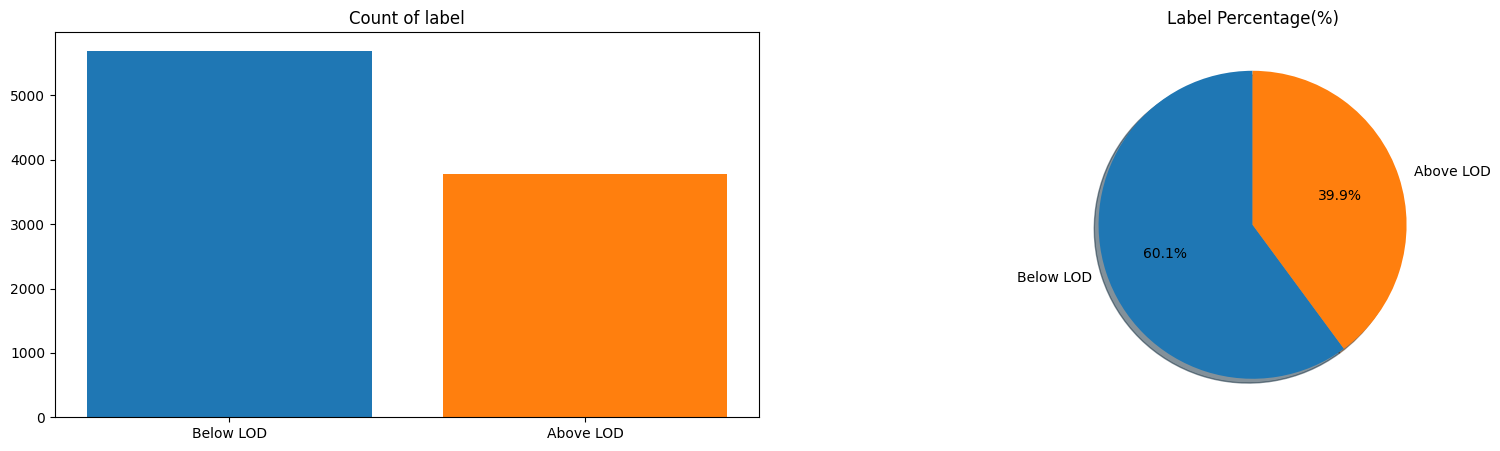

In [17]:
y_labels = np.where(df[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
label_value = np.unique(y_labels, return_counts = True)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

axes[1].pie(label_value[1], labels=['Below LOD', 'Above LOD'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%)')
axes[0].bar(label_value[0], label_value[1], tick_label=['Below LOD', 'Above LOD'], align='center', color=sns.color_palette())
axes[0].set_title('Count of label')

In [18]:
X_TRAIN = train_data.iloc[:,-N_WAVELENGTH:]
Y_TRAIN = np.where(train_data[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)

Text(0.5, 1.0, 'Label Percentage(%) after SMOTE')

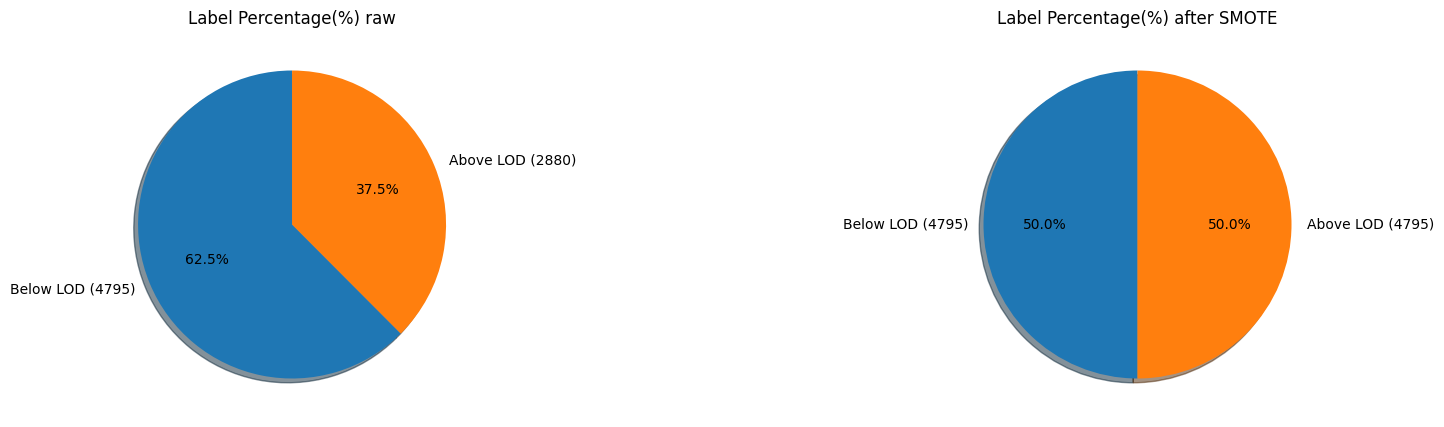

In [260]:
from imblearn.over_sampling import SMOTE
over_sample = SMOTE()
X_TRAIN_SMOTE, Y_TRAIN_SMOTE = over_sample.fit_resample(X_TRAIN, Y_TRAIN)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

y_train_smote = np.unique(Y_TRAIN_SMOTE, return_counts = True)
y_train_raw = np.unique(Y_TRAIN, return_counts = True)

axes[0].pie(y_train_raw[1], labels=[f'Below LOD ({y_train_raw[1][0]})', f'Above LOD ({y_train_raw[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Label Percentage(%) raw')

axes[1].pie(y_train_smote[1], labels=[f'Below LOD ({y_train_smote[1][0]})', f'Above LOD ({y_train_smote[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%) after SMOTE')

Chia dữ liệu TEST (không dùng SMOTE)

Text(0.5, 1.0, 'Count of label')

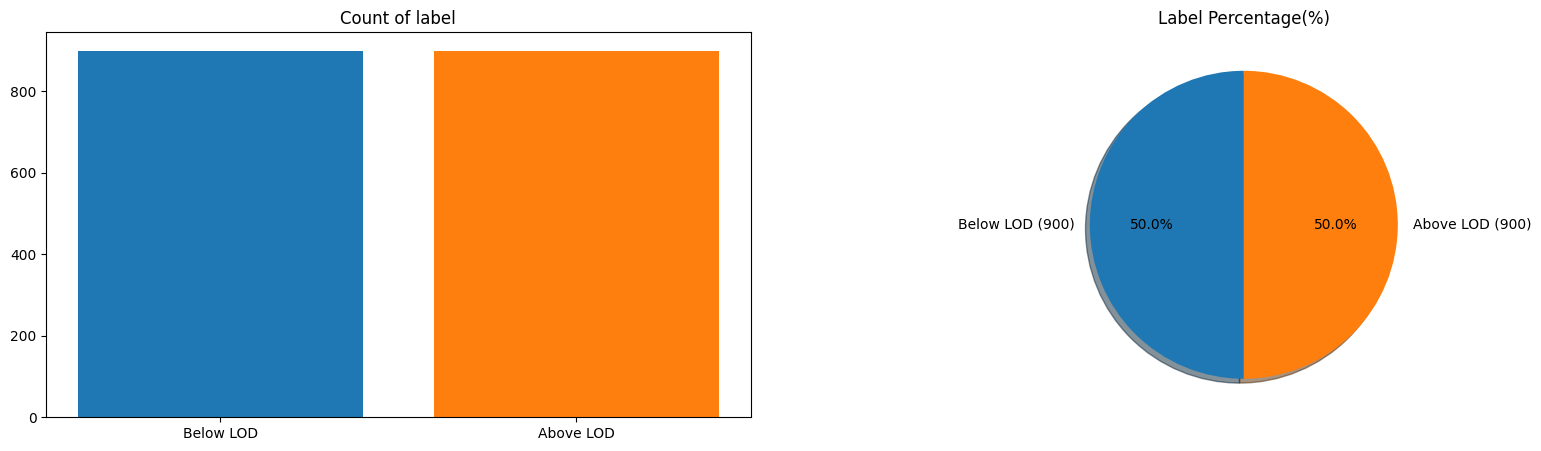

In [262]:
X_TEST = test_data.iloc[:,-N_WAVELENGTH:]
Y_TEST = np.where(test_data[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
y_test_raw = np.unique(Y_TEST, return_counts = True)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

axes[1].pie(y_test_raw[1], labels=[f'Below LOD ({y_test_raw[1][0]})', f'Above LOD ({y_test_raw[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%)')
axes[0].bar(y_test_raw[0], y_test_raw[1], tick_label=['Below LOD', 'Above LOD'], align='center', color=sns.color_palette())
axes[0].set_title('Count of label')

# Tiền xử lý

Savizky-Golay 

In [21]:
def my_SG(X, deriv=0):
    return savgol_filter(X, window_length=25, polyorder=5, deriv=deriv)

In [23]:
def snv(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        temp_mean = temp_nir.mean()
        temp_std = temp_nir.std(ddof=0)
        df_output.iloc[i,-N_WAVELENGTH:] = (df_output.iloc[i,-N_WAVELENGTH:] - temp_mean) / temp_std
    return df_output

def msc(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    df_input = (df_input.T - np.mean(df_input.T, axis=0)).T
    ref = np.mean(df_input, axis=0)

    for i in range(df_input.shape[0]):
        # Run regression
        fit = np.polyfit(ref, df_input.iloc[i,:], 1, full=True)
        # Apply correction
        df_output.iloc[i,-N_WAVELENGTH:] = (df_input.iloc[i,:] - fit[0][1]) / fit[0][0] 
    return df_output

def my_MinMaxScaler(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        x_min = min(df_output.iloc[i,-N_WAVELENGTH:])
        x_max = max(df_output.iloc[i,-N_WAVELENGTH:])
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - x_min) / (x_max - x_min)
    return df_output

def my_RobustScaler(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        Q1 = np.percentile(temp_nir, 25)
        median = np.percentile(temp_nir, 50)
        Q3 = np.percentile(temp_nir, 75)
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - median) / (Q3 - Q1)
    return df_output


In [24]:
def my_preprocess_data(X_data, feature='sg0', normalization = 'msc'):
    X_data_prep = X_data

    if normalization == 'msc':
        X_data_prep = msc(X_data)
    elif normalization == 'snv':
        X_data_prep = snv(X_data)
    elif normalization == 'minmax':
        X_data_prep = my_MinMaxScaler(X_data)
    elif normalization == 'robust':
        X_data_prep = my_RobustScaler(X_data)
        
    if feature == 'sg0':
        X_data_prep = my_SG(X_data_prep, 0)
    elif feature == 'sg1':
        X_data_prep = my_SG(X_data_prep, 1)
    elif feature == 'sg2':
        X_data_prep = my_SG(X_data_prep, 2)
    elif feature == 'sg1 + sg2':
        X_data_SG1 = my_SG(X_data_prep, 1)
        X_data_SG2 = my_SG(X_data_prep, 2)
        X_data_prep = np.hstack([X_data_SG1, X_data_SG2])
        
    return X_data_prep

# Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


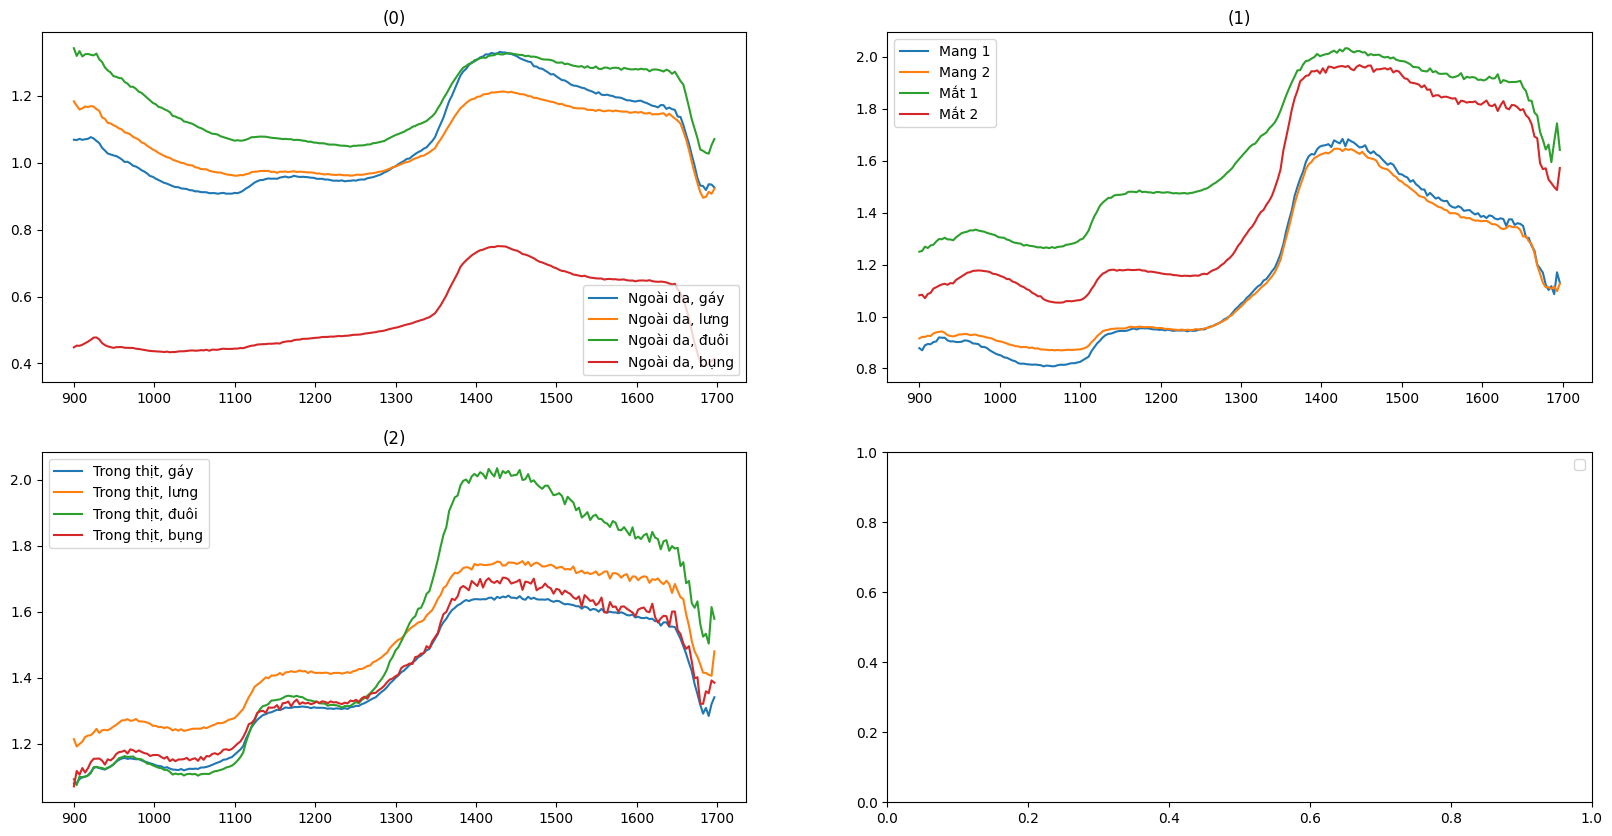

In [248]:
fig, axes = plt.subplots(2, 2, sharex=False, figsize=(20,10))
fish_id = np.random.choice(df['Mã mẫu cá'])
fish_id = 691
WL = np.arange(900, 1700, 800/228)
types = list(df['Loại cá'].unique())
for a in range(2):
    for b in range(2):
        i = a*2 + b 
        for position in list(test_data['Vị trí đo'].unique())[i*4:(i+1)*4]:
    
            nirs_of_fish = df[df['Mã mẫu cá'] == fish_id]
            nirs_of_fish_at_position = nirs_of_fish[nirs_of_fish['Vị trí đo'] == position]

            axes[a][b].plot(WL, nirs_of_fish_at_position.iloc[1,-N_WAVELENGTH:], label=position)
            axes[a][b].set_title(f'({i})')
            
        axes[a][b].legend()

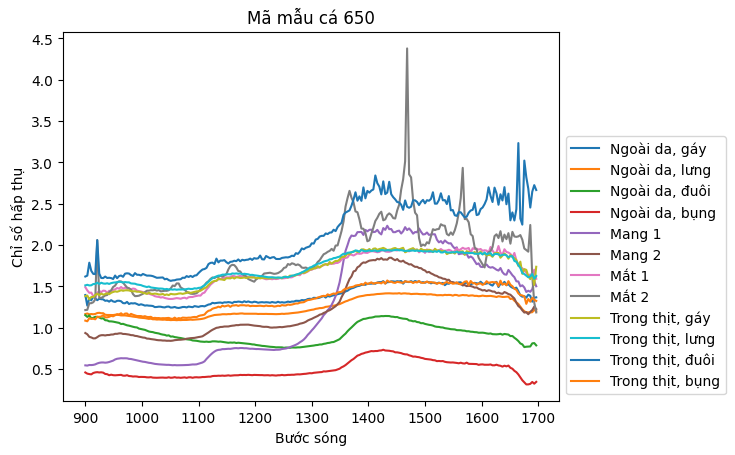

In [250]:
WL = np.arange(900, 1700, 800/228)

for position in list(test_data['Vị trí đo'].unique()):
    fish_id = np.random.choice(df['Mã mẫu cá'])
    nirs_of_fish = df[df['Mã mẫu cá'] == fish_id]
    nirs_of_fish_at_position = nirs_of_fish[nirs_of_fish['Vị trí đo'] == position]

    plt.plot(WL, nirs_of_fish_at_position.iloc[1,-N_WAVELENGTH:], label=position)
plt.xlabel('Bước sóng')
plt.ylabel('Chỉ số hấp thụ')
plt.title(f'Mã mẫu cá {fish_id}')
plt.legend(bbox_to_anchor=(1,0), loc="lower left")

In [265]:
sample = []
for type in df['Loại cá'].unique():
    c = df[df['Loại cá'].str.contains(type)].reset_index()
    sample.append(c.iloc[31,-228:].to_numpy())
    
X_sample = pd.DataFrame(sample)
wl = np.arange(900, 1700, 800/228)

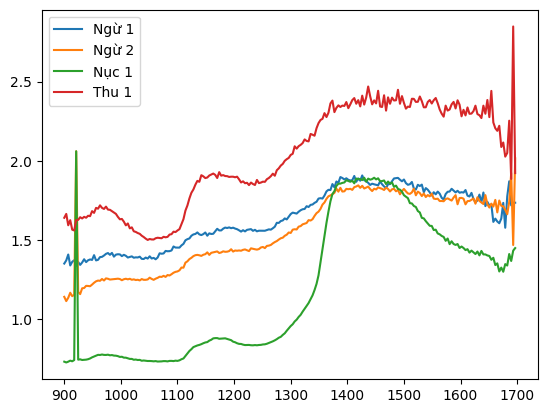

In [266]:
for i, type_fiss in enumerate(df['Loại cá'].unique()):
    plt.plot(wl, (X_sample).iloc[i,:], label=type_fiss)
plt.legend()

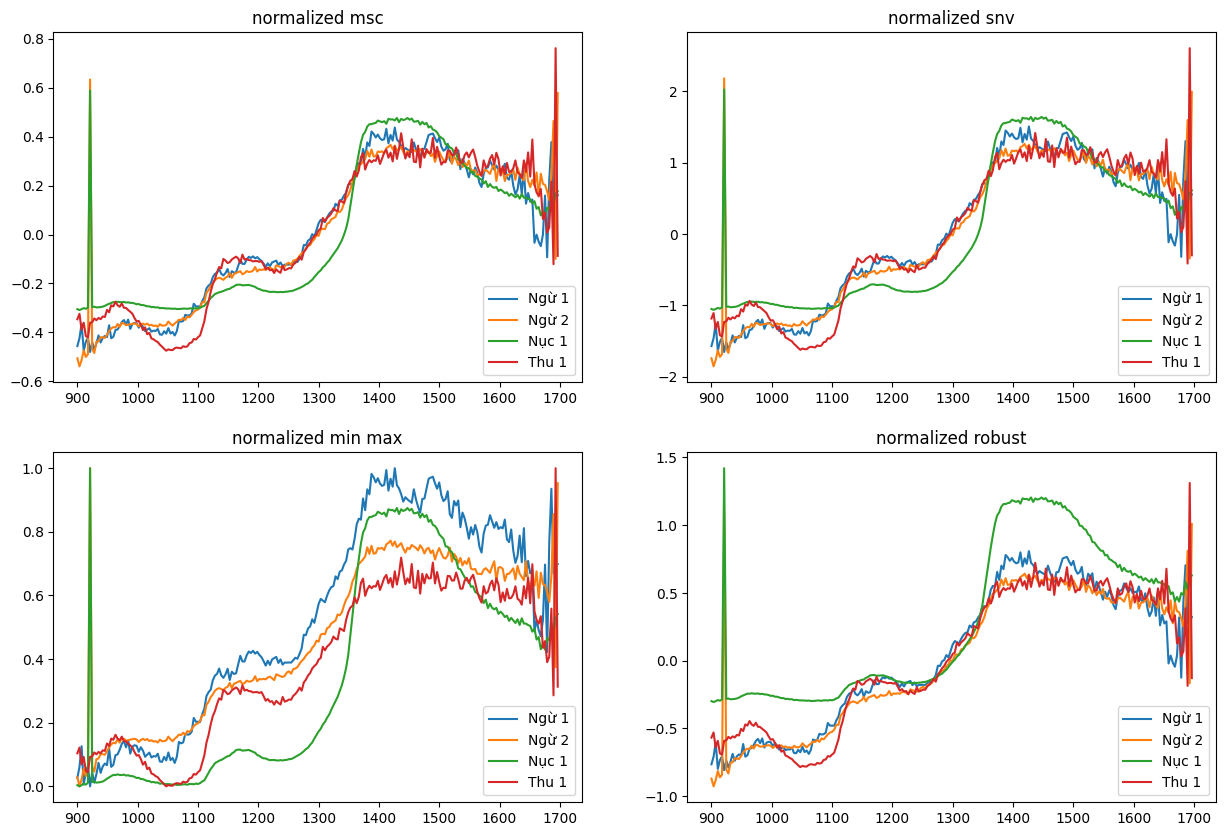

In [267]:
X_Robust = my_RobustScaler(X_sample)
X_minmax = my_MinMaxScaler(X_sample)
X_msc = msc(X_sample)
X_snv = snv(X_sample)

my_list = [X_msc, X_snv, X_minmax, X_Robust]
name = ['normalized msc', 'normalized snv', 'normalized min max', 'normalized robust']

fig, ax = plt.subplots(2, 2, figsize=(15,10))

i2 = 0
for a in range(2):
    for b in range(2):
        for i, type_fiss in enumerate(df['Loại cá'].unique()):
            ax[a][b].plot(wl, (my_list[i2]).iloc[i,:], label=type_fiss)
            ax[a][b].set_title(name[i2])
        ax[a][b].legend()
        i2 += 1

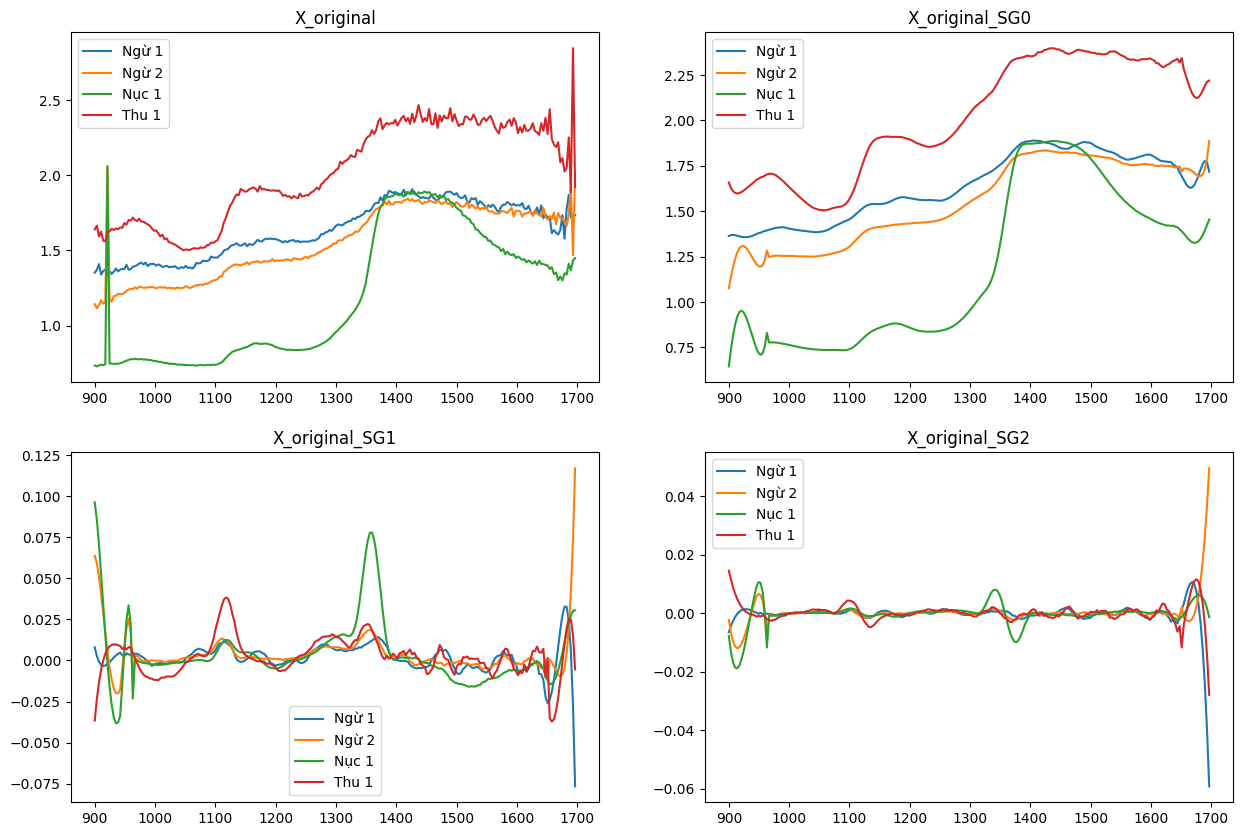

In [268]:
def plot_spectral(data, name_data):
    fig, ax = plt.subplots(2, 2, figsize=(15,10))

    X_SG0 = pd.DataFrame(my_SG(data, deriv=0))
    X_SG1 = pd.DataFrame(my_SG(data, deriv=1))
    X_SG2 = pd.DataFrame(my_SG(data, deriv=2))

    my_list = [data, X_SG0, X_SG1, X_SG2 ]
    name = [f'X_{name_data}', f'X_{name_data}_SG0', f'X_{name_data}_SG1', f'X_{name_data}_SG2']

    wl = np.arange(900, 1700, 800/228)
    i2 =0
    for a in range(2):
        for b in range(2):
            for i, type_fiss in enumerate(df['Loại cá'].unique()):
                ax[a][b].plot(wl, (my_list[i2]).iloc[i,:], label=type_fiss)
                ax[a][b].set_title(name[i2])
            ax[a][b].legend()
            i2 += 1
        
plot_spectral(X_sample, 'original')

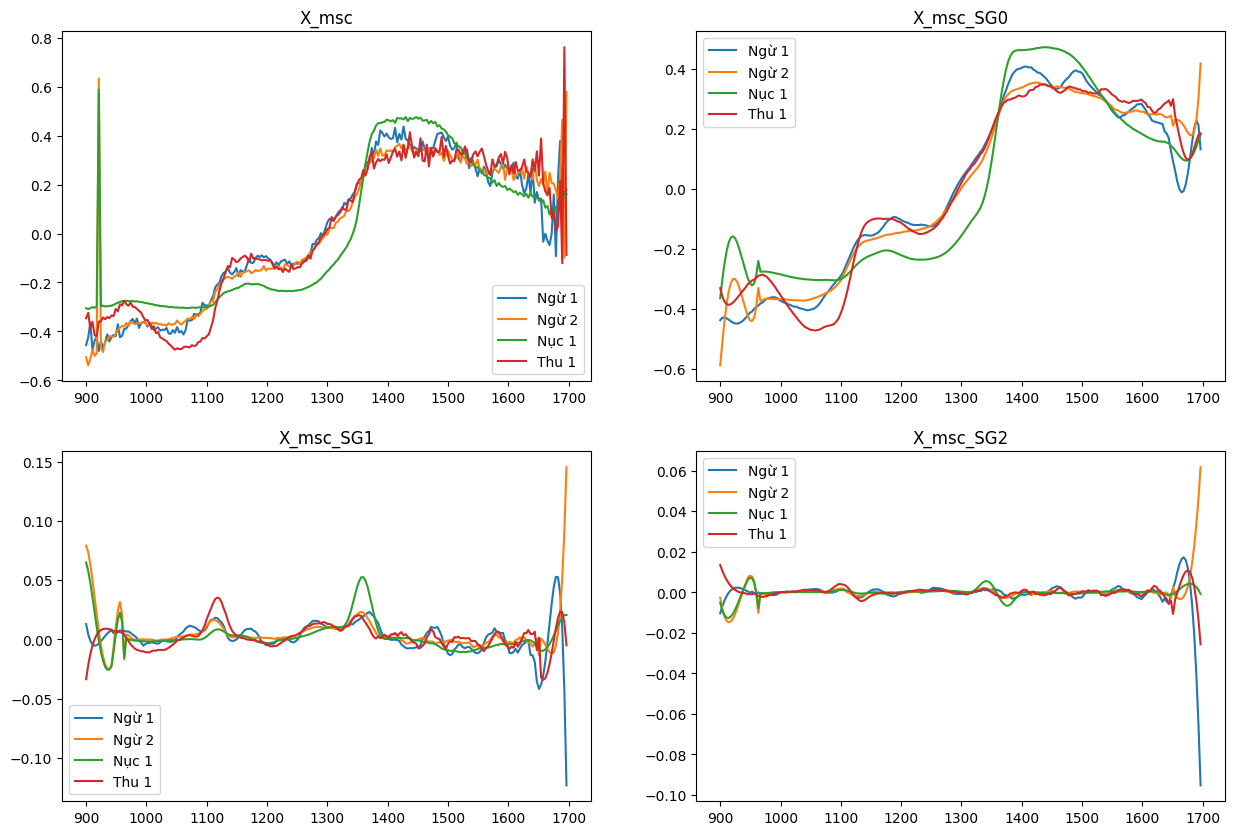

In [269]:
plot_spectral(X_msc, 'msc')

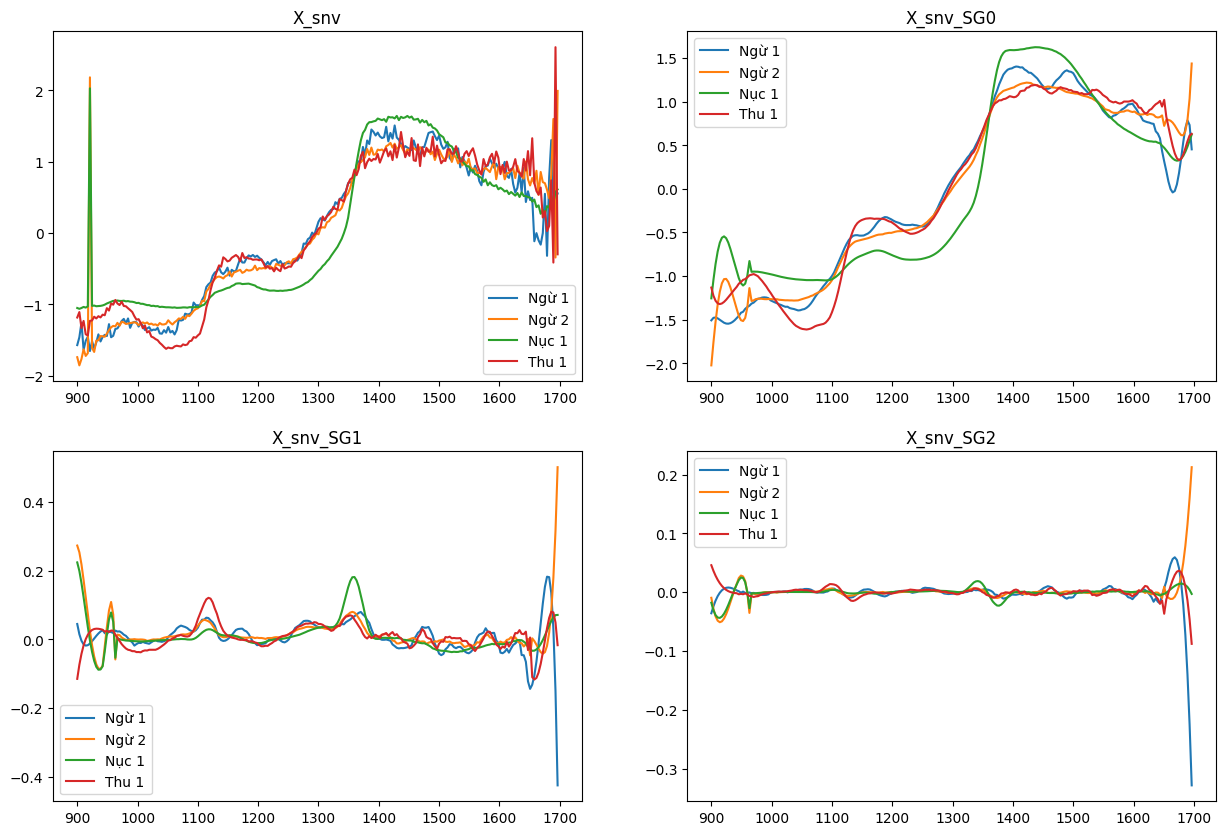

In [270]:
plot_spectral(X_snv, 'snv')

# chọn các đặt trưng tối ưu

In [25]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def get_optimal_wavelength(X, y, top_n_features=10):
    best_features = SelectKBest(score_func=f_classif, k=top_n_features)
    fit = best_features.fit(X, y)

    return list(fit.get_feature_names_out())

In [26]:
# dữ liệu train và test đã dùng SMOTE
X_DATA = pd.concat([X_TRAIN_SMOTE, X_TEST], axis=0)
Y_DATA = np.hstack((Y_TRAIN_SMOTE, Y_TEST))

# KNN

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
skf = StratifiedKFold(n_splits=5)

In [71]:
acc_max = 0
optimal_n_neighbors = 0
n_optimal_wavelength_knn = []

for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(X_DATA, Y_DATA, n_wl)
    #n_wavelength = [int(i) - (train_data.shape[1]-N_WAVELENGTH) for i in n_wavelength]
    n_wavelength = [int(i) - 1 for i in n_wavelength]
    for k in range(3,62,2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
        y_pred_knn = knn.predict(X_TEST.iloc[:,n_wavelength])
        acc = accuracy_score(Y_TEST, y_pred_knn)
        
        if acc > acc_max:
            acc_max = acc
            optimal_n_neighbors = k
            n_optimal_wavelength_knn = n_wavelength
print(acc_max, len(n_optimal_wavelength_knn), optimal_n_neighbors)

0.6444444444444445 110 11


In [73]:
knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)
knn.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
y_pred_knn = knn.predict(X_TEST)
accuracy_score(Y_TEST, y_pred_knn)

0.6344444444444445

In [74]:
print(f'Parameter for KNN, k = {optimal_n_neighbors}')

Parameter for KNN, k = 11


In [30]:
def my_KNN(X_train, y_train, X_test, y_test):
    
    knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100

    return acc

In [75]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_knn = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_knn]
        X_train = my_preprocess_data(X_train_,feature=feature, normalization=normal)
        
        X_test_ = X_TEST.iloc[:,n_optimal_wavelength_knn]
        X_test = my_preprocess_data(X_test_,feature=feature, normalization=normal)
        
        acc = my_KNN(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)
        print(acc)
        acc_knn.append(acc)

65.889
65.61099999999999
64.833
65.667
66.889
67.111
67.111
67.111
64.667
65.167
64.22200000000001
65.72200000000001
67.167
67.72200000000001
66.944
67.167


In [76]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_knn2 = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE
        X_train = my_preprocess_data(X_train_,feature=feature, normalization=normal)
        
        X_test_ = X_TEST
        X_test = my_preprocess_data(X_test_,feature=feature, normalization=normal)
        
        acc = my_KNN(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)
        print(acc)
        acc_knn2.append(acc)

66.333
66.389
68.22200000000001
67.778
66.944
67.05600000000001
65.72200000000001
66.833
63.111
62.444
62.556
63.611
66.111
66.389
65.11099999999999
66.778


In [114]:
print(np.mean(acc_knn), np.mean(acc_knn2))

66.1875 65.71175


# Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [77]:
best_criterion = ''
best_acc = 0
best_max_depth = 0
best_min_samples_leaf = 0
for criterion in ['gini', 'entropy']:
    for depth in range(3, 20):
        for samples_leaf in range(3, 20):
            dtc = DecisionTreeClassifier(criterion=criterion, max_depth=depth, min_samples_leaf=samples_leaf)
            dtc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
            y_pred_dtc = dtc.predict(X_TEST)
            acc = accuracy_score(Y_TEST, y_pred_dtc)
            
            if acc > best_acc:
                best_acc = acc
                best_criterion = criterion
                best_max_depth = depth
                best_min_samples_leaf = samples_leaf
                
print(f'best accuracy: {best_acc} with criterion: {best_criterion} max_depth: {best_max_depth} best_min_samples_leaf: {best_min_samples_leaf}')

best accuracy: 0.6622222222222223 with criterion: gini max_depth: 17 best_min_samples_leaf: 18


In [78]:
best_acc2 = 0
n_optimal_wavelength_dt = []
for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(X_DATA, Y_DATA, n_wl)
    n_wavelength = [int(i) - 1 for i in n_wavelength]

    dtc = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
    dtc.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
    y_pred_dtc = dtc.predict(X_TEST.iloc[:,n_wavelength])
    acc = accuracy_score(Y_TEST, y_pred_dtc)
    
    if acc > best_acc2:
        best_acc2 = acc
        n_optimal_wavelength_dt = n_wavelength
        
print(best_acc2, len(n_optimal_wavelength_dt))

0.6488888888888888 190


In [35]:
def my_DecisionTree(X_train, y_train, X_test, y_test):
     
    dtc = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth, 
                                 min_samples_leaf=best_min_samples_leaf)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100
    
    return acc

In [79]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_dt = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_dt]
        X_train = my_preprocess_data(X_train_,feature=feature, normalization=normal)
        
        X_test_ = X_TEST.iloc[:,n_optimal_wavelength_dt]
        X_test = my_preprocess_data(X_test_,feature=feature, normalization=normal)
        
        acc = my_DecisionTree(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)
        print(acc)
        acc_dt.append(acc)

67.72200000000001
64.333
63.444
67.333
65.444
67.167
68.111
68.444
66.167
66.111
66.5
67.778
66.0
66.167
67.5
66.889


In [80]:
# sử dụng tất cả đặt trưng

all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_dt2 = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE
        X_train = my_preprocess_data(X_train_,feature=feature, normalization=normal)
        
        X_test_ = X_TEST
        X_test = my_preprocess_data(X_test_,feature=feature, normalization=normal)
        
        acc = my_DecisionTree(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)
        print(acc)
        acc_dt2.append(acc)

67.611
62.833000000000006
62.5
62.388999999999996
64.389
66.167
62.722
67.444
65.0
64.444
63.278
63.722
64.278
66.22200000000001
65.5
69.611


# Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
best_acc_rfc = 0
best_n_estimators = 0

for n_tree in range(100,301,10):
    rfc = RandomForestClassifier(n_estimators=n_tree, criterion=best_criterion, max_depth=best_max_depth,
                                    min_samples_leaf=best_min_samples_leaf)
    rfc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
    y_pred = rfc.predict(X_TEST)
    acc_rfc = accuracy_score(Y_TEST, y_pred)
    if acc_rfc > best_acc_rfc:
        best_acc_rfc = acc_rfc
        best_n_estimators = n_tree


In [40]:
print(best_acc_rfc, best_n_estimators)

0.6761111111111111 220


In [41]:
best_acc_rfc2 = 0
n_optimal_wavelength_rf = []

for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(X_DATA, Y_DATA, n_wl)
    n_wavelength = [int(i) - 1 for i in n_wavelength]
    
    rfc = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion, max_depth=best_max_depth,
                                    min_samples_leaf=best_min_samples_leaf)
    rfc.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
    y_pred = rfc.predict(X_TEST.iloc[:,n_wavelength])
    acc_rfc2 = accuracy_score(Y_TEST, y_pred)
    if acc_rfc2 > best_acc_rfc2:
        best_acc_rfc2 = acc_rfc2
        n_optimal_wavelength_rf = n_wavelength
     
print(best_acc_rfc2, len(n_optimal_wavelength_rf))   

0.6783333333333333 150


In [42]:
def my_RandomForest(X_train, y_train, X_test, y_test):
        
    rfc = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion, max_depth=best_max_depth,
                                    min_samples_leaf=best_min_samples_leaf)
    rfc.fit(X_train, y_train.ravel())

    y_pred = rfc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    return np.round(acc, 5)*100

In [43]:
# sử dụng 1 phần các đặt trưng

all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_rf = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_rf]
        X_train = my_preprocess_data(X_train_,feature=feature, normalization=normal)
        
        X_test_ = X_TEST.iloc[:,n_optimal_wavelength_rf]
        X_test = my_preprocess_data(X_test_,feature=feature, normalization=normal)
        
        acc = my_RandomForest(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)
        print(acc)
        acc_rf.append(acc)

69.111
69.94399999999999
69.389
68.278
70.333
70.722
71.5
71.667
68.0
68.333
68.111
69.111
69.44399999999999
69.111
69.833
70.0


In [44]:
# sử dụng tất cả đặt trưng

all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_rf2 = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE
        X_train = my_preprocess_data(X_train_,feature=feature, normalization=normal)
        
        X_test_ = X_TEST
        X_test = my_preprocess_data(X_test_,feature=feature, normalization=normal)
        
        acc = my_RandomForest(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)
        print(acc)
        acc_rf2.append(acc)

72.0
71.667
68.167
71.611
70.5
70.889
70.722
71.167
69.94399999999999
69.611
68.0
69.94399999999999
71.667
71.167
70.44399999999999
71.222


In [115]:
print(np.mean(acc_rf), np.mean(acc_rf2))

69.55543750000001 70.46175


# SVM

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [54]:
best_acc_svm = 0
best_c = 0
best_kernel = ''

for kernel in ['linear', 'rbf']:
    for c in range(-3,4):
        svc = SVC(kernel=kernel, C=10**int(c)) 
        svc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
        y_pred = svc.predict(X_TEST)
        acc = accuracy_score(Y_TEST, y_pred)
        
        if acc > best_acc_svm:
            best_acc_svm = acc
            best_c = 10**int(c)
            best_kernel = kernel

In [55]:
print(f'kernel: {best_kernel}, C: {best_c} => accuracy: {best_acc_svm}')

kernel: rbf, C: 1000 => accuracy: 0.7272222222222222


In [56]:
best_acc_svm = 0
n_optimal_wavelength_svm = []

for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(X_DATA, Y_DATA, n_wl)
    n_wavelength = [int(i) - 1 for i in n_wavelength]
    
    svc = SVC(kernel=best_kernel, C=best_c) 
    svc.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
    y_pred = svc.predict(X_TEST.iloc[:,n_wavelength])
    acc_svm = accuracy_score(Y_TEST, y_pred)

    if acc_svm > best_acc_svm:
        best_acc_svm = acc_svm
        n_optimal_wavelength_svm = n_wavelength
        
print(best_acc_svm, len(n_optimal_wavelength_svm))

0.7166666666666667 190


In [57]:
def my_SVM(X_train, y_train, X_test, y_test):
    
    # default SVM (rbf kernel)
    svc = SVC(kernel=best_kernel, C=best_c) 
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100

    return acc

In [141]:
# sử dụng tất cả đặt trưng

all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_svm2 = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE
        X_train = my_preprocess_data(X_train_,feature=feature, normalization=normal)
        
        X_test_ = X_TEST
        X_test = my_preprocess_data(X_test_,feature=feature, normalization=normal)
        
        acc = my_SVM(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)
        print(acc)
        acc_svm2.append(acc)

69.5
71.88900000000001
71.389
70.77799999999999
71.667
74.056
71.88900000000001
73.111
69.389
71.5
70.833
71.722
71.0
73.944
72.0
73.056


# CNN

In [60]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, Activation, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [61]:
from keras.utils.np_utils import to_categorical
y_train_smote_encode = to_categorical(Y_TRAIN_SMOTE, num_classes = 2)
y_test_encode = to_categorical(Y_TEST, num_classes = 2)

In [62]:
def my_CNN(X_train_val, y_train_val, X_test, y_test):
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size = 0.25, random_state=42)
    
    model = Sequential([
        Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train_val.shape[1],1)),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),
        
        Conv1D(filters=32, kernel_size=5, activation='relu'),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),
        
        Conv1D(filters=64, kernel_size=11, activation='relu'),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),

        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dropout(0.01),
        Dense(2,activation='softmax')
    ])
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=0.000001, verbose = 1)
    early_stop = EarlyStopping(patience=50)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    his = model.fit(X_train, y_train, batch_size=64, epochs=1000, validation_data=(X_val, y_val), callbacks=[early_stop, learning_rate_reduction])
    
    evaluate_train = model.evaluate(X_train, y_train)
    evaluate_val = model.evaluate(X_val, y_val)
    evaluate_test = model.evaluate(X_test, y_test)
    
    return his, evaluate_train[1], evaluate_val[1], evaluate_test[1]

In [63]:
my_CNN(X_TRAIN_SMOTE, y_train_smote_encode, X_TEST, y_test_encode)


Epoch 1/1000
113/113 [==============================] - 2s 13ms/step - loss: 0.6851 - accuracy: 0.5291 - val_loss: 0.6425 - val_accuracy: 0.6051 - lr: 5.0000e-04
Epoch 2/1000
113/113 [==============================] - 1s 11ms/step - loss: 0.6280 - accuracy: 0.5982 - val_loss: 0.6081 - val_accuracy: 0.6681 - lr: 5.0000e-04
Epoch 3/1000
113/113 [==============================] - 1s 11ms/step - loss: 0.6049 - accuracy: 0.6370 - val_loss: 0.5716 - val_accuracy: 0.6827 - lr: 5.0000e-04
Epoch 4/1000
113/113 [==============================] - 1s 11ms/step - loss: 0.5948 - accuracy: 0.6488 - val_loss: 0.5956 - val_accuracy: 0.6343 - lr: 5.0000e-04
Epoch 5/1000
113/113 [==============================] - 1s 11ms/step - loss: 0.5742 - accuracy: 0.6719 - val_loss: 0.5284 - val_accuracy: 0.7256 - lr: 5.0000e-04
Epoch 6/1000
113/113 [==============================] - 1s 11ms/step - loss: 0.5549 - accuracy: 0.6941 - val_loss: 0.5318 - val_accuracy: 0.7415 - lr: 5.0000e-04
Epoch 7/1000
113/113 [======

(<keras.callbacks.History at 0x171dc454290>,
 0.9972191452980042,
 0.9649708271026611,
 0.7049999833106995)

In [64]:
best_acc_cnn = 0
n_optimal_wavelength_cnn = []
for n_wl in range(70, 201, 20):
    n_wavelength = get_optimal_wavelength(X_DATA, Y_DATA, n_wl)
    n_wavelength = [int(i) - 1 for i in n_wavelength]
        
    result = my_CNN(X_TRAIN_SMOTE.iloc[:, n_wavelength], y_train_smote_encode, X_TEST.iloc[:, n_wavelength], y_test_encode)
    evaluate_test = result[3]
    if evaluate_test > best_acc_cnn:
        best_acc_cnn = evaluate_test
        n_optimal_wavelength_cnn = n_wavelength

Epoch 1/1000
113/113 [==============================] - 1s 6ms/step - loss: 0.6927 - accuracy: 0.5053 - val_loss: 0.6893 - val_accuracy: 0.5092 - lr: 5.0000e-04
Epoch 2/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.6606 - accuracy: 0.5895 - val_loss: 0.5908 - val_accuracy: 0.6789 - lr: 5.0000e-04
Epoch 3/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.6477 - val_loss: 0.5784 - val_accuracy: 0.6810 - lr: 5.0000e-04
Epoch 4/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.5866 - accuracy: 0.6599 - val_loss: 0.6566 - val_accuracy: 0.6097 - lr: 5.0000e-04
Epoch 5/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.5877 - accuracy: 0.6675 - val_loss: 0.5659 - val_accuracy: 0.6793 - lr: 5.0000e-04
Epoch 6/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.5733 - accuracy: 0.6751 - val_loss: 0.5396 - val_accuracy: 0.7118 - lr: 5.0000e-04
Epoch 7/1000
113/113 [============

In [65]:
print(f'best accuracy: {best_acc_cnn}, number of optimal wavelength {len(n_optimal_wavelength_cnn)}')

best accuracy: 0.7177777886390686, number of optimal wavelength 190


In [68]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

HISTORY = []
for feature in ['sg0', 'sg1']:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_cnn]
        X_test_ = X_TEST.iloc[:,n_optimal_wavelength_cnn]
        X_train = my_preprocess_data(X_train_,feature=feature, normalization=normal)
        X_test = my_preprocess_data(X_test_,feature=feature, normalization=normal)
        HISTORY.append(my_CNN(X_train, y_train_smote_encode, X_test, y_test_encode))

Epoch 1/1000
113/113 [==============================] - 2s 15ms/step - loss: 0.6761 - accuracy: 0.5665 - val_loss: 0.6406 - val_accuracy: 0.6560 - lr: 5.0000e-04
Epoch 2/1000
113/113 [==============================] - 2s 13ms/step - loss: 0.6253 - accuracy: 0.6386 - val_loss: 0.5902 - val_accuracy: 0.6718 - lr: 5.0000e-04
Epoch 3/1000
113/113 [==============================] - 2s 13ms/step - loss: 0.5830 - accuracy: 0.6649 - val_loss: 0.5712 - val_accuracy: 0.6676 - lr: 5.0000e-04
Epoch 4/1000
113/113 [==============================] - 1s 13ms/step - loss: 0.5619 - accuracy: 0.6874 - val_loss: 0.5361 - val_accuracy: 0.7048 - lr: 5.0000e-04
Epoch 5/1000
113/113 [==============================] - 1s 13ms/step - loss: 0.5532 - accuracy: 0.6910 - val_loss: 0.5350 - val_accuracy: 0.6935 - lr: 5.0000e-04
Epoch 6/1000
113/113 [==============================] - 2s 14ms/step - loss: 0.5395 - accuracy: 0.6959 - val_loss: 0.5347 - val_accuracy: 0.7043 - lr: 5.0000e-04
Epoch 7/1000
113/113 [======

In [69]:
for feature in ['sg2', 'sg1 + sg2']:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_cnn]
        X_test_ = X_TEST.iloc[:,n_optimal_wavelength_cnn]
        X_train = my_preprocess_data(X_train_,feature=feature, normalization=normal)
        X_test = my_preprocess_data(X_test_,feature=feature, normalization=normal)
        
        HISTORY.append(my_CNN(X_train, y_train_smote_encode, X_test, y_test_encode))

Epoch 1/1000
113/113 [==============================] - 2s 12ms/step - loss: 0.6819 - accuracy: 0.5501 - val_loss: 0.6280 - val_accuracy: 0.6284 - lr: 5.0000e-04
Epoch 2/1000
113/113 [==============================] - 1s 11ms/step - loss: 0.6177 - accuracy: 0.6254 - val_loss: 0.6160 - val_accuracy: 0.6230 - lr: 5.0000e-04
Epoch 3/1000
113/113 [==============================] - 1s 12ms/step - loss: 0.5928 - accuracy: 0.6507 - val_loss: 0.5677 - val_accuracy: 0.6701 - lr: 5.0000e-04
Epoch 4/1000
113/113 [==============================] - 1s 11ms/step - loss: 0.5674 - accuracy: 0.6834 - val_loss: 0.5562 - val_accuracy: 0.6839 - lr: 5.0000e-04
Epoch 5/1000
113/113 [==============================] - 1s 10ms/step - loss: 0.5581 - accuracy: 0.6874 - val_loss: 0.5207 - val_accuracy: 0.7281 - lr: 5.0000e-04
Epoch 6/1000
113/113 [==============================] - 1s 10ms/step - loss: 0.5382 - accuracy: 0.7095 - val_loss: 0.5091 - val_accuracy: 0.7256 - lr: 5.0000e-04
Epoch 7/1000
113/113 [======

In [70]:
for i in HISTORY:
    print([np.round(x,5)*100 for x in i[1:]])

[99.36, 94.746, 73.056]
[99.778, 96.163, 73.611]
[98.91499999999999, 94.621, 72.38900000000001]
[99.736, 94.704, 72.5]
[97.038, 88.532, 70.556]
[99.764, 91.034, 71.833]
[98.012, 89.616, 71.667]
[98.387, 90.075, 70.889]
[97.177, 89.324, 71.833]
[98.902, 89.199, 72.38900000000001]
[95.731, 87.94800000000001, 70.611]
[95.439, 89.158, 70.722]
[98.707, 90.45, 72.667]
[99.555, 90.28399999999999, 71.167]
[99.569, 91.827, 72.833]
[99.235, 91.493, 72.833]


In [123]:
for i in HISTORY:
    # print([np.round(x,5)*100 for x in i[1:]])
    print(np.round(i[-1],5)*100)

73.056
73.611
72.38900000000001
72.5
70.556
71.833
71.667
70.889
71.833
72.38900000000001
70.611
70.722
72.667
71.167
72.833
72.833


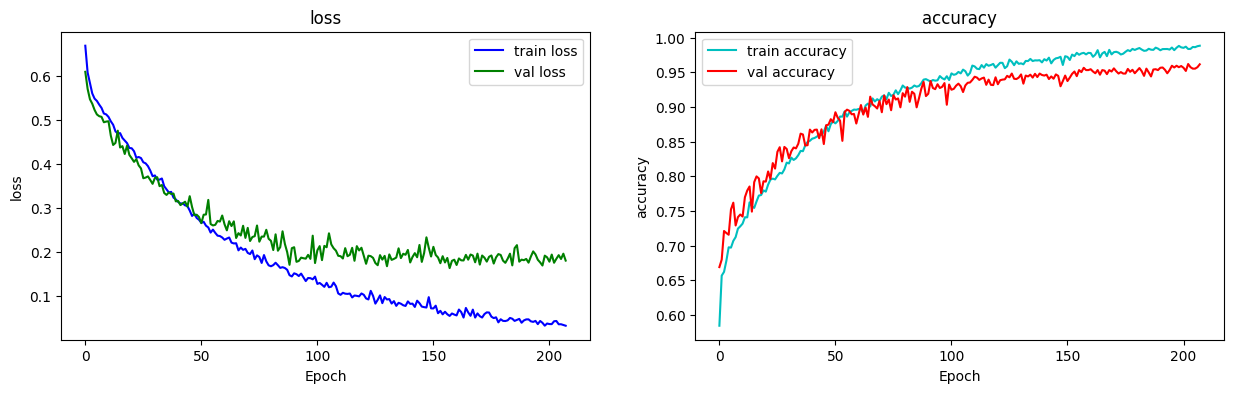

In [83]:
s, (at, al) = plt.subplots(1, 2, figsize=(15,4))

at.plot(HISTORY[1][0].history['loss'], 'b', label='train loss')
at.plot(HISTORY[1][0].history['val_loss'], 'g', label='val loss')
at.set_title('loss')
at.set_xlabel('Epoch')
at.set_ylabel('loss')
at.legend()

al.plot(HISTORY[1][0].history['accuracy'], 'c', label='train accuracy')
al.plot(HISTORY[1][0].history['val_accuracy'], 'r', label='val accuracy')
al.set_title('accuracy')
al.set_xlabel('Epoch')
al.set_ylabel('accuracy')
al.legend()

# Sử dụng mô hình CNN đo các vị trí của cá

In [152]:
def training_CNN(X_train_val, y_train_val):
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size = 0.25, random_state=42)
    
    model = Sequential([
        Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train_val.shape[1],1)),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),
        
        Conv1D(filters=32, kernel_size=5, activation='relu'),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),
        
        Conv1D(filters=64, kernel_size=11, activation='relu'),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),

        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dropout(0.01),
        Dense(2,activation='softmax')
    ])
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=0.000001, verbose = 1)
    early_stop = EarlyStopping(patience=50)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    his = model.fit(X_train, y_train, batch_size=64, epochs=1000, validation_data=(X_val, y_val), callbacks=[early_stop, learning_rate_reduction])
    
    return his, model

repeated hold out

In [82]:
def get_random_test_fish_id(df):
    TEST_SIZE = 0.2

    fish_numbers = df['STT mẫu cá'].unique()

    histamine_value = []
    for number in fish_numbers:
        sub_df = df[df['STT mẫu cá'] == number]
        # print(stt, sub_df['Urea'].value_counts())
        histamine_value.append(sub_df[NAME_COLUMNS_HISTAMINE].iloc[1])
    y_labels = np.where(np.array(histamine_value) >= LOD_HISTAMINE, 1, 0)

    number_test_fish = int(len(fish_numbers)*TEST_SIZE)

    indices_below_LOD = np.where(y_labels == 0)[0]
    test_indices_below_LOD = np.random.choice(indices_below_LOD, size=number_test_fish//2, replace=False)
    test_fish_numbers_below_LOD = fish_numbers[test_indices_below_LOD]

    indices_above_LOD = np.where(y_labels == 1)[0]
    test_indices_above_LOD = np.random.choice(indices_above_LOD, size=number_test_fish//2, replace=False)
    test_fish_numbers_above_LOD = fish_numbers[test_indices_above_LOD]

    test_fish_number = np.hstack((test_fish_numbers_above_LOD, test_fish_numbers_below_LOD))
    
    return test_fish_number

def train_smote_and_test_by_test_fish_id(df, test_id_fish:list):
    test_data = pd.DataFrame()
    train_data = df.copy()
    for i in test_id_fish:
        sub_df = df[df['STT mẫu cá'] == i]
        test_data = pd.concat([test_data, sub_df], axis=0)
        
        train_data = train_data.drop(train_data[train_data['STT mẫu cá'] == i].index)
        
    return train_data, test_data

def my_split_train_test(train_data, test_data):
    x_train = train_data.iloc[:,-N_WAVELENGTH:]
    y_train = np.where(train_data[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
    over_sample = SMOTE()
    x_train_smote, y_train_smote = over_sample.fit_resample(x_train, y_train)
    
    x_test = test_data.iloc[:,-N_WAVELENGTH:]
    y_test = np.where(test_data[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
    
    return x_train_smote, y_train_smote, x_test, y_test

In [101]:
TIME_REPEAT_HOLD_OUT = 10
result = {}
list_model = []
for times in range(TIME_REPEAT_HOLD_OUT):
    accuracy_each_position = []
    
    test_fish_id = get_random_test_fish_id(df)
    train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)
    X_TRAIN_SMOTE, Y_TRAIN_SMOTE, X_TEST, Y_TEST = my_split_train_test(train_data, test_data)
    
    X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_cnn]
    X_train = my_preprocess_data(X_train_, feature='sg0', normalization='snv')
    y_train_smote_encode = to_categorical(Y_TRAIN_SMOTE, num_classes = 2)
    
    my_model_cnn = training_CNN(X_train, y_train_smote_encode)[1]
    
    for position in list(test_data['Vị trí đo'].unique()):
        sub_data_TEST = test_data[test_data['Vị trí đo'] == position]
        
        sub_X_TEST = sub_data_TEST.iloc[:, -N_WAVELENGTH:]
        sub_X_TEST_ = sub_X_TEST.iloc[:,n_optimal_wavelength_cnn]
        sub_X_TEST_prep = my_preprocess_data(sub_X_TEST_, feature='sg0', normalization='snv')
        
        sub_Y_TEST = np.where(sub_data_TEST[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
        sub_Y_TEST_encode = to_categorical(sub_Y_TEST, num_classes = 2)
        
        acc_cnn = my_model_cnn.evaluate(sub_X_TEST_prep, sub_Y_TEST_encode)
        accuracy_each_position.append(acc_cnn)
        print(f'Lần: {times+1}, Vị trí : {position}  ==>  độ chính xác: {acc_cnn}')
        
    result[times] = accuracy_each_position
    list_model.append(my_model_cnn)
    print('='*40)

Epoch 1/1000
113/113 [==============================] - 2s 14ms/step - loss: 0.6568 - accuracy: 0.5891 - val_loss: 0.6359 - val_accuracy: 0.6155 - lr: 5.0000e-04
Epoch 2/1000
113/113 [==============================] - 1s 13ms/step - loss: 0.6096 - accuracy: 0.6464 - val_loss: 0.6207 - val_accuracy: 0.6230 - lr: 5.0000e-04
Epoch 3/1000
113/113 [==============================] - 1s 12ms/step - loss: 0.5915 - accuracy: 0.6520 - val_loss: 0.6300 - val_accuracy: 0.5967 - lr: 5.0000e-04
Epoch 4/1000
113/113 [==============================] - 1s 13ms/step - loss: 0.5775 - accuracy: 0.6660 - val_loss: 0.5716 - val_accuracy: 0.6718 - lr: 5.0000e-04
Epoch 5/1000
113/113 [==============================] - 1s 13ms/step - loss: 0.5638 - accuracy: 0.6805 - val_loss: 0.5642 - val_accuracy: 0.6918 - lr: 5.0000e-04
Epoch 6/1000
113/113 [==============================] - 1s 13ms/step - loss: 0.5518 - accuracy: 0.6910 - val_loss: 0.5614 - val_accuracy: 0.6993 - lr: 5.0000e-04
Epoch 7/1000
113/113 [======

In [102]:
accuracy_each_position = []

for position in list(train_data['Vị trí đo'].unique()):
    sub_data_TEST = test_data[test_data['Vị trí đo'] == position]
    sub_X_TEST = sub_data_TEST.iloc[:, -N_WAVELENGTH:]
    sub_Y_TEST = np.where(sub_data_TEST[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
    
    print(f'Vị trí : {position}  ==>  độ chính xác: {np.unique(sub_Y_TEST, return_counts=True)}')

Vị trí : Ngoài da, gáy  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Ngoài da, lưng  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Ngoài da, đuôi  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Ngoài da, bụng  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Mang 1  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Mang 2  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Mắt 1  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Mắt 2  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Trong thịt, gáy  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Trong thịt, lưng  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Trong thịt, đuôi  ==>  độ chính xác: (array([0, 1]), array([75, 75], dtype=int64))
Vị trí : Trong thịt, bụng  ==>  độ chính

In [108]:
result[1][1][1]

0.7866666913032532

In [133]:
for i, position in enumerate(list(df['Vị trí đo'].unique())):
    sub_list_acc = []
    for j in range(TIME_REPEAT_HOLD_OUT):
        acc = result[j][i][1]
        sub_list_acc.append(acc)
    print('Vị trí: {} ==> độ chính xác trung binh: {:.3f}'.format(position, np.mean(sub_list_acc)*100))

Vị trí: Ngoài da, gáy ==> độ chính xác trung binh: 71.694
Vị trí: Ngoài da, lưng ==> độ chính xác trung binh: 76.237
Vị trí: Ngoài da, đuôi ==> độ chính xác trung binh: 71.200
Vị trí: Ngoài da, bụng ==> độ chính xác trung binh: 79.000
Vị trí: Mang 1 ==> độ chính xác trung binh: 76.667
Vị trí: Mang 2 ==> độ chính xác trung binh: 74.200
Vị trí: Mắt 1 ==> độ chính xác trung binh: 76.467
Vị trí: Mắt 2 ==> độ chính xác trung binh: 72.000
Vị trí: Trong thịt, gáy ==> độ chính xác trung binh: 70.000
Vị trí: Trong thịt, lưng ==> độ chính xác trung binh: 72.400
Vị trí: Trong thịt, đuôi ==> độ chính xác trung binh: 74.667
Vị trí: Trong thịt, bụng ==> độ chính xác trung binh: 75.600


In [135]:
for i, position in enumerate(list(df['Vị trí đo'].unique())):
    sub_list_acc = []
    for j in range(TIME_REPEAT_HOLD_OUT):
        acc = result[j][i][1]
        sub_list_acc.append(acc)
    print('{:.3f}'.format(np.mean(sub_list_acc)*100))

71.694
76.237
71.200
79.000
76.667
74.200
76.467
72.000
70.000
72.400
74.667
75.600


Cross validation

In [110]:
from sklearn.model_selection import StratifiedKFold
K_FOLD = 5
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=1)
TEST_SIZE = 0.2

fish_numbers = df['STT mẫu cá'].unique()

ure_value = []
for number in fish_numbers:
    sub_df = df[df['STT mẫu cá'] == number]
    # print(stt, sub_df['Urea'].value_counts())
    ure_value.append(sub_df[NAME_COLUMNS_HISTAMINE].iloc[1])
    
y_labels = np.where(np.array(ure_value) > LOD_HISTAMINE, 1, 0)

In [54]:
np.unique(y_labels, return_counts=True)[1]

array([87, 12], dtype=int64)

In [111]:
result_cv = {}
list_model_cv = []
for times, (train_index, test_index) in enumerate(skf.split(ure_value, y_labels)):
    accuracy_each_position = []
    
    test_fish_id = fish_numbers[test_index]
    train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)
    X_TRAIN_SMOTE, Y_TRAIN_SMOTE, X_TEST, Y_TEST = my_split_train_test(train_data, test_data)
    
    X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_cnn]
    X_train = my_preprocess_data(X_train_, feature='sg0', normalization='snv')
    y_train_smote_encode = to_categorical(Y_TRAIN_SMOTE, num_classes = 2)
    
    my_model_cnn = training_CNN(X_train, y_train_smote_encode)[1]
    
    for position in list(test_data['Vị trí đo'].unique()):
        sub_data_TEST = test_data[test_data['Vị trí đo'] == position]
        
        sub_X_TEST = sub_data_TEST.iloc[:, -N_WAVELENGTH:]
        sub_X_TEST_ = sub_X_TEST.iloc[:,n_optimal_wavelength_cnn]
        sub_X_TEST_prep = my_preprocess_data(sub_X_TEST_, feature='sg0', normalization='snv')
        
        sub_Y_TEST = np.where(sub_data_TEST[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
        sub_Y_TEST_encode = to_categorical(sub_Y_TEST, num_classes = 2)
        
        acc_cnn = my_model_cnn.evaluate(sub_X_TEST_prep, sub_Y_TEST_encode)
        accuracy_each_position.append(acc_cnn)
        print(f'Lần: {times+1}, Vị trí : {position}  ==>  độ chính xác: {acc_cnn}')
        
    result_cv[times] = accuracy_each_position
    list_model_cv.append(my_model_cnn)
    print('='*40)

Epoch 1/1000
113/113 [==============================] - 2s 15ms/step - loss: 0.6614 - accuracy: 0.5830 - val_loss: 0.6915 - val_accuracy: 0.5542 - lr: 5.0000e-04
Epoch 2/1000
113/113 [==============================] - 2s 14ms/step - loss: 0.6193 - accuracy: 0.6310 - val_loss: 0.6126 - val_accuracy: 0.6447 - lr: 5.0000e-04
Epoch 3/1000
113/113 [==============================] - 2s 14ms/step - loss: 0.5944 - accuracy: 0.6555 - val_loss: 0.5824 - val_accuracy: 0.6701 - lr: 5.0000e-04
Epoch 4/1000
113/113 [==============================] - 2s 14ms/step - loss: 0.5698 - accuracy: 0.6735 - val_loss: 0.5666 - val_accuracy: 0.6718 - lr: 5.0000e-04
Epoch 5/1000
113/113 [==============================] - 2s 14ms/step - loss: 0.5589 - accuracy: 0.6845 - val_loss: 0.5490 - val_accuracy: 0.7048 - lr: 5.0000e-04
Epoch 6/1000
113/113 [==============================] - 2s 13ms/step - loss: 0.5552 - accuracy: 0.6904 - val_loss: 0.5346 - val_accuracy: 0.7023 - lr: 5.0000e-04
Epoch 7/1000
113/113 [======

In [138]:
for i, position in enumerate(list(df['Vị trí đo'].unique())):
    sub_list_acc_cv = []
    for j in range(K_FOLD):
        acc = result_cv[j][i][1]
        sub_list_acc_cv.append(acc)
    print('Vị trí: {} ==> độ chính xác trung binh: {:.3f}'.format(position, np.mean(sub_list_acc_cv)*100))

Vị trí: Ngoài da, gáy ==> độ chính xác trung binh: 70.933
Vị trí: Ngoài da, lưng ==> độ chính xác trung binh: 65.867
Vị trí: Ngoài da, đuôi ==> độ chính xác trung binh: 63.200
Vị trí: Ngoài da, bụng ==> độ chính xác trung binh: 80.933
Vị trí: Mang 1 ==> độ chính xác trung binh: 71.333
Vị trí: Mang 2 ==> độ chính xác trung binh: 75.200
Vị trí: Mắt 1 ==> độ chính xác trung binh: 72.400
Vị trí: Mắt 2 ==> độ chính xác trung binh: 63.200
Vị trí: Trong thịt, gáy ==> độ chính xác trung binh: 70.667
Vị trí: Trong thịt, lưng ==> độ chính xác trung binh: 72.667
Vị trí: Trong thịt, đuôi ==> độ chính xác trung binh: 74.933
Vị trí: Trong thịt, bụng ==> độ chính xác trung binh: 79.600


In [139]:
for i, position in enumerate(list(df['Vị trí đo'].unique())):
    sub_list_acc_cv = []
    for j in range(K_FOLD):
        acc = result_cv[j][i][1]
        sub_list_acc_cv.append(acc)
    print('{:.3f}'.format( np.mean(sub_list_acc_cv)*100))

70.933
65.867
63.200
80.933
71.333
75.200
72.400
63.200
70.667
72.667
74.933
79.600


# Sử dụng mô hình SVM đo các vị trí của cá

In [184]:
TIME_REPEAT_HOLD_OUT = 10
result_SVM = {}

for times in range(TIME_REPEAT_HOLD_OUT):
    accuracy_each_position = []
    
    test_fish_id = get_random_test_fish_id(df)
    train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)
    X_TRAIN_SMOTE, Y_TRAIN_SMOTE, X_TEST, Y_TEST = my_split_train_test(train_data, test_data)
    
    X_train_ = X_TRAIN_SMOTE
    X_train = my_preprocess_data(X_train_, feature='sg1', normalization='snv')
    
    svm = SVC(kernel=best_kernel, C=best_c) 
    svm.fit(X_train, Y_TRAIN_SMOTE)
    
    for position in list(test_data['Vị trí đo'].unique()):
        sub_data_TEST = test_data[test_data['Vị trí đo'] == position]
        
        sub_X_TEST = sub_data_TEST.iloc[:, -N_WAVELENGTH:]
        sub_X_TEST_ = sub_X_TEST
        sub_X_TEST_prep = my_preprocess_data(sub_X_TEST_, feature='sg1', normalization='snv')
        
        sub_Y_TEST = np.where(sub_data_TEST[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
        
        y_pred = svm.predict(sub_X_TEST_prep)
        acc_svm = accuracy_score(sub_Y_TEST, y_pred)
        accuracy_each_position.append(acc_svm)
        print(f'Lần: {times+1}, Vị trí : {position}  ==>  độ chính xác: {acc_svm}')
        
    result_SVM[times] = accuracy_each_position
    print('='*40)

Lần: 1, Vị trí : Ngoài da, gáy  ==>  độ chính xác: 0.82
Lần: 1, Vị trí : Ngoài da, lưng  ==>  độ chính xác: 0.7733333333333333
Lần: 1, Vị trí : Ngoài da, đuôi  ==>  độ chính xác: 0.7666666666666667
Lần: 1, Vị trí : Ngoài da, bụng  ==>  độ chính xác: 0.7466666666666667
Lần: 1, Vị trí : Mang 1  ==>  độ chính xác: 0.72
Lần: 1, Vị trí : Mang 2  ==>  độ chính xác: 0.7266666666666667
Lần: 1, Vị trí : Mắt 1  ==>  độ chính xác: 0.7
Lần: 1, Vị trí : Mắt 2  ==>  độ chính xác: 0.7466666666666667
Lần: 1, Vị trí : Trong thịt, gáy  ==>  độ chính xác: 0.72
Lần: 1, Vị trí : Trong thịt, lưng  ==>  độ chính xác: 0.78
Lần: 1, Vị trí : Trong thịt, đuôi  ==>  độ chính xác: 0.78
Lần: 1, Vị trí : Trong thịt, bụng  ==>  độ chính xác: 0.7466666666666667
Lần: 2, Vị trí : Ngoài da, gáy  ==>  độ chính xác: 0.8333333333333334
Lần: 2, Vị trí : Ngoài da, lưng  ==>  độ chính xác: 0.7933333333333333
Lần: 2, Vị trí : Ngoài da, đuôi  ==>  độ chính xác: 0.7866666666666666
Lần: 2, Vị trí : Ngoài da, bụng  ==>  độ chính xá

In [185]:
for i, position in enumerate(list(df['Vị trí đo'].unique())):
    sub_list_acc = []
    for j in range(TIME_REPEAT_HOLD_OUT):
        acc = result_SVM[j][i]
        sub_list_acc.append(acc)
    print('Vị trí: {} ==> độ chính xác trung binh: {:.3f}'.format(position, np.mean(sub_list_acc)*100))

Vị trí: Ngoài da, gáy ==> độ chính xác trung binh: 82.733
Vị trí: Ngoài da, lưng ==> độ chính xác trung binh: 80.000
Vị trí: Ngoài da, đuôi ==> độ chính xác trung binh: 77.933
Vị trí: Ngoài da, bụng ==> độ chính xác trung binh: 78.200
Vị trí: Mang 1 ==> độ chính xác trung binh: 80.400
Vị trí: Mang 2 ==> độ chính xác trung binh: 78.133
Vị trí: Mắt 1 ==> độ chính xác trung binh: 72.667
Vị trí: Mắt 2 ==> độ chính xác trung binh: 75.400
Vị trí: Trong thịt, gáy ==> độ chính xác trung binh: 76.133
Vị trí: Trong thịt, lưng ==> độ chính xác trung binh: 75.536
Vị trí: Trong thịt, đuôi ==> độ chính xác trung binh: 79.733
Vị trí: Trong thịt, bụng ==> độ chính xác trung binh: 76.733


cross validation

In [156]:
from sklearn.model_selection import StratifiedKFold
K_FOLD = 5
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=1)
TEST_SIZE = 0.2

fish_numbers = df['STT mẫu cá'].unique()

ure_value = []
for number in fish_numbers:
    sub_df = df[df['STT mẫu cá'] == number]
    # print(stt, sub_df['Urea'].value_counts())
    ure_value.append(sub_df[NAME_COLUMNS_HISTAMINE].iloc[1])
    
y_labels = np.where(np.array(ure_value) > LOD_HISTAMINE, 1, 0)

In [168]:
result_cv_SVM = {}
list_confuse_matrix_cv_SVM = {}
for times, (train_index, test_index) in enumerate(skf.split(ure_value, y_labels)):
    accuracy_each_position = []
    confuse_matrix_each_position = []
    
    test_fish_id = fish_numbers[test_index]
    train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)
    X_TRAIN_SMOTE, Y_TRAIN_SMOTE, X_TEST, Y_TEST = my_split_train_test(train_data, test_data)
    
    X_train_ = X_TRAIN_SMOTE
    X_train = my_preprocess_data(X_train_, feature='sg1', normalization='snv')
    
    svm = SVC(kernel=best_kernel, C=best_c) 
    svm.fit(X_train, Y_TRAIN_SMOTE)
    
    for position in list(test_data['Vị trí đo'].unique()):
        sub_data_TEST = test_data[test_data['Vị trí đo'] == position]
        
        sub_X_TEST = sub_data_TEST.iloc[:, -N_WAVELENGTH:]
        sub_X_TEST_ = sub_X_TEST
        sub_X_TEST_prep = my_preprocess_data(sub_X_TEST_, feature='sg1', normalization='snv')
        
        sub_Y_TEST = np.where(sub_data_TEST[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
        
        y_pred = svm.predict(sub_X_TEST_prep)
        acc_svm = accuracy_score(sub_Y_TEST, y_pred)
        
        accuracy_each_position.append(acc_svm)
        confuse_matrix_each_position.append(metrics.confusion_matrix(sub_Y_TEST, y_pred))
        
        print(f'Lần: {times+1}, Vị trí : {position}  ==>  độ chính xác: {acc_svm}')
        
    result_cv_SVM[times] = accuracy_each_position
    list_confuse_matrix_cv_SVM[times] = confuse_matrix_each_position
    print('='*40)

Lần: 1, Vị trí : Ngoài da, gáy  ==>  độ chính xác: 0.86875
Lần: 1, Vị trí : Ngoài da, lưng  ==>  độ chính xác: 0.85
Lần: 1, Vị trí : Ngoài da, đuôi  ==>  độ chính xác: 0.8
Lần: 1, Vị trí : Ngoài da, bụng  ==>  độ chính xác: 0.775
Lần: 1, Vị trí : Mang 1  ==>  độ chính xác: 0.6875
Lần: 1, Vị trí : Mang 2  ==>  độ chính xác: 0.84375
Lần: 1, Vị trí : Mắt 1  ==>  độ chính xác: 0.73125
Lần: 1, Vị trí : Mắt 2  ==>  độ chính xác: 0.84375
Lần: 1, Vị trí : Trong thịt, gáy  ==>  độ chính xác: 0.68125
Lần: 1, Vị trí : Trong thịt, lưng  ==>  độ chính xác: 0.73125
Lần: 1, Vị trí : Trong thịt, đuôi  ==>  độ chính xác: 0.75
Lần: 1, Vị trí : Trong thịt, bụng  ==>  độ chính xác: 0.83125
Lần: 2, Vị trí : Ngoài da, gáy  ==>  độ chính xác: 0.74375
Lần: 2, Vị trí : Ngoài da, lưng  ==>  độ chính xác: 0.825
Lần: 2, Vị trí : Ngoài da, đuôi  ==>  độ chính xác: 0.81875
Lần: 2, Vị trí : Ngoài da, bụng  ==>  độ chính xác: 0.8
Lần: 2, Vị trí : Mang 1  ==>  độ chính xác: 0.75625
Lần: 2, Vị trí : Mang 2  ==>  độ chí

In [173]:
for i, position in enumerate(list(df['Vị trí đo'].unique())):
    sub_list_acc = []
    for j in range(K_FOLD):
        acc = result_cv_SVM[j][i]
        sub_list_acc.append(acc)
    print('{:.3f}'.format(np.mean(sub_list_acc)*100))

80.225
80.679
78.173
78.565
77.645
77.198
73.899
77.435
72.270
73.153
74.427
76.706


In [ ]:
confuse_matrix = []
for i in range(K_FOLD):
    matrix = list_confuse_matrix_cv_SVM[i][1]
    confuse_matrix.append(np.array(matrix))
    tp = matrix[0][0]
    fp = matrix[0][1]
    tn = matrix[1][1]
    fn = matrix[1][0]
    precision = tp / (tp + fp)
    recall =  tp / (tp + fn)
    f1_score = (2*precision*recall)/(precision + recall)

<Axes: >

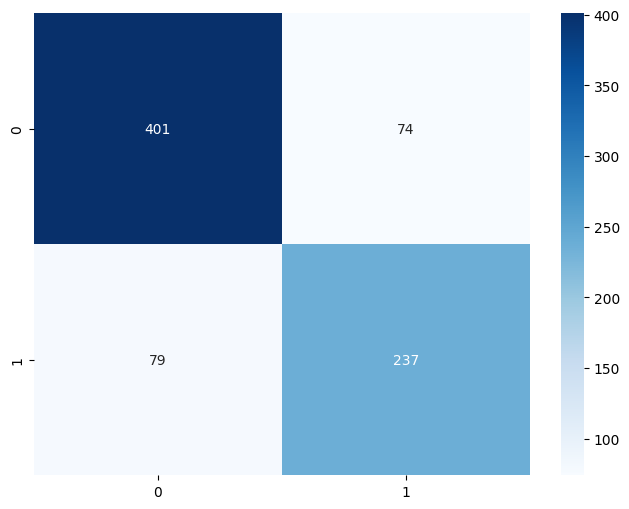

In [274]:
import seaborn as sn
plt.figure(figsize = (8,6))
df_cm = pd.DataFrame(sum(confuse_matrix), range(2), range(2))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')